In [1]:
from pyiron_atomistics import Project
from atomrdf import KnowledgeGraph, System
import numpy as np

In [2]:
from pyiron_workflow import Workflow
from python.pyironflow import PyironFlow

In [3]:
@Workflow.wrap.as_function_node
def CreateProject(pr_name: str, element: str):
    pr = Project(pr_name)
    kg1 = KnowledgeGraph()
    kg1.enable_workflow(pr, workflow_environment='pyiron')
    pr_kg_el = {'project': pr, 'kg': kg1, 'element': element}
    return pr_kg_el

In [4]:
@Workflow.wrap.as_function_node
def CreateSample(pr_kg_el, cubic: bool = False):
    pr = pr_kg_el['project']
    element = pr_kg_el['element']
    structure = pr.create.structure.annotated_structure.bulk(element, cubic=cubic)
    return structure

In [5]:
@Workflow.wrap.as_function_node("View")
def VisualizeStructure(structure):
    return structure.plot3D

In [6]:
@Workflow.wrap.as_function_node("sample_KG")
def SampleKG(pr_kg_el):
    kg1 = pr_kg_el['kg']
    element = pr_kg_el['element']
    eval_string = "System.create.element."+element+"(graph=kg1)"
    struct_el = eval(eval_string)
    return kg1.visualise(size=(120,30),hide_types=True, layout='dot')

In [7]:
@Workflow.wrap.as_function_node
def LammpsCalcMinimize(pr_kg_el, structure, job_name:str, del_ex_job: bool, pot_list_index: int, f_tol: float, min_style: str):
    pr = pr_kg_el['project']
    job = pr.create.job.Lammps(job_name, delete_existing_job=del_ex_job)
    job.structure = structure
    job.potential = job.list_potentials()[pot_list_index]
    job.calc_minimize(f_tol=f_tol, style=min_style)
    job.run()
    import os
    os.system('conda env export | grep -v "^prefix: " > ' + job.project.name + '/' + job.name + '_environment.yml')
    from pyiron_base.storage.hdfio import FileHDFio
    hdf = FileHDFio(job.project.name + '/' + job.name + '_input_structure.h5')
    job.structure.to_hdf(hdf)
    return job

In [8]:
@Workflow.wrap.as_function_node("view")
def ViewStructure(structure):
    return structure.plot3d()

In [9]:
@Workflow.wrap.as_function_node("job_KG")
def JobKG(pr_kg_el, job):
    kg1 = pr_kg_el['kg']
    kg1.add_workflow(job, workflow_environment='pyiron')
    return kg1.visualise(workflow_view=True, hide_types=True, size=(40,20), layout='dot')

In [10]:
@Workflow.wrap.as_function_node("job_concept_dict")
def JobConceptDict(pr_kg_el, job):
    import json
    pr = pr_kg_el['project']
    cdict = process_job(job)
    file_name = pr.name + '/' + job.name + '_concept_dict.json'
    with open(file_name, 'w') as f:
        json.dump(cdict, f, indent=2)
    return print(json.dumps(cdict, indent=2))

In [11]:
@Workflow.wrap.as_function_node("object")
def LammpsJobOpenBIS(username:str, space:str, project:str, collection:str, job):
    import json
    cdict_file = job.path + '_concept_dict.json'
    try:
        with open(cdict_file) as json_file:
            concept_dict = json.load(json_file)
            concept_dict = flatten_cdict(concept_dict)
    except:
        print("======================\n")
        print("Create a conceptual dictionary first!\n")
        print("======================\n")
        concept_dict = None
    return JobOpenBIS(username, space, project, collection, concept_dict, job)

In [12]:
wf = Workflow("test_wf")

wf.Project_KG_Element = CreateProject("test_gui", "Fe")
wf.Structure = CreateSample(wf.Project_KG_Element, True)
wf.ViewStructure = ViewStructure(wf.Structure)
wf.SampleKG = SampleKG(wf.Project_KG_Element)
wf.LammpsCalcMinimize = LammpsCalcMinimize(wf.Project_KG_Element, wf.Structure, "test_lammps_gui", True, 68, 1e-8, "fire")
wf.JobKG = JobKG(wf.Project_KG_Element, wf.LammpsCalcMinimize)
wf.JobConceptDict = JobConceptDict(wf.Project_KG_Element, wf.LammpsCalcMinimize)
wf.LammpsJobOpenBIS = LammpsJobOpenBIS("tlakshmi", "TLAKSHMI", "TEST", "TEST_EXP_1", wf.LammpsCalcMinimize)

In [13]:
pf = PyironFlow([wf])
pf.gui

In [14]:
pf.out_widget

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [15]:
from pybis import Openbis
o = Openbis('https://test3.datastore.bam.de/')          # https:// is assumed

import getpass
password = getpass.getpass()

o.login('tlakshmi', password, save_token=True)   # save the session token in ~/.pybis/example.com.token

 ········


'tlakshmi-241014122351337x8FB53A8EF504B32FF8038597B07D48F8'

In [16]:
#o.logout()

In [17]:
print(f"Session is active: {o.is_session_active()} and token is {o.token}")

Session is active: True and token is tlakshmi-241014122351337x8FB53A8EF504B32FF8038597B07D48F8


In [31]:
wf_from_gui = pf.get_workflow()

In [32]:
obis_job = wf_from_gui.LammpsCalcMinimize.pull()

/home/tlakshmi/anaconda3/envs/pyiron_unify_1/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/tlakshmi/anaconda3/envs/pyiron_unify_1/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/tlakshmi/anaconda3/envs/pyiron_unify_1/lib/python3.11/site-packages/pyiron_atomistics/lammps/interactive.py:302: UserWarning: f_tol is deprecated as of vers. 0.3.0. It is not guaranteed to be in service in vers. 0.4.0. Use ionic_force_tolerance instead.
  warnings.warn(


The job test_lammps_gui was saved and received the ID: 47


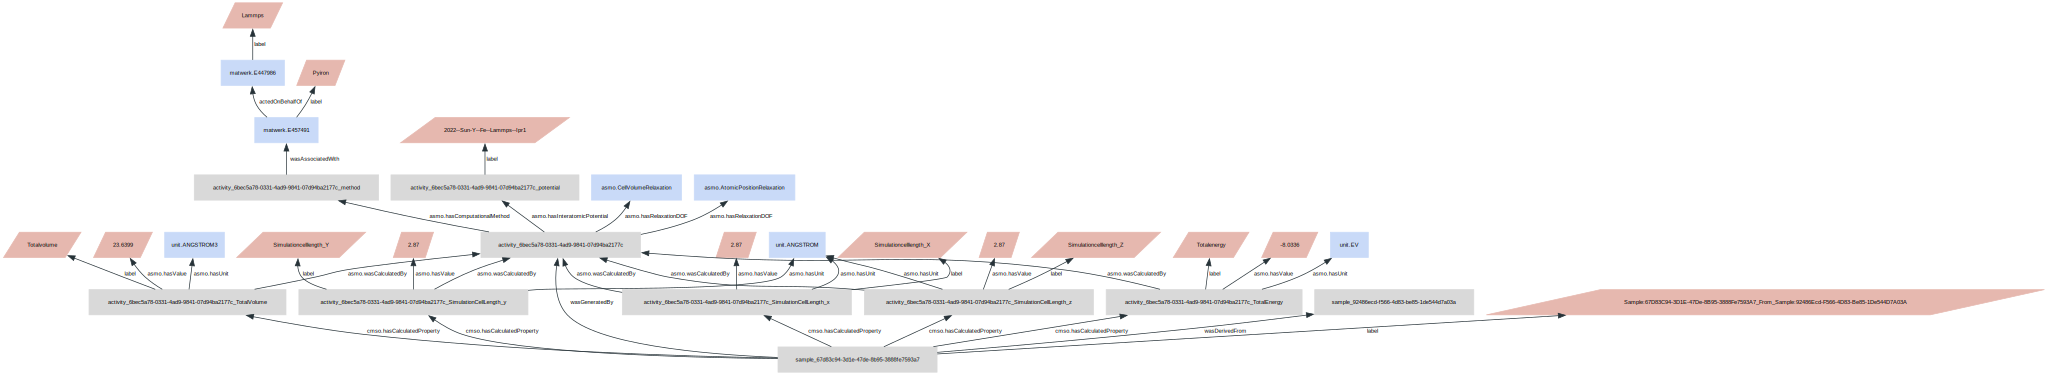

In [35]:
wf_from_gui.JobKG.pull()

In [33]:
wf_from_gui.JobConceptDict.pull()

{
  "@context": {
    "sample": "http://purls.helmholtz-metadaten.de/cmso/AtomicScaleSample",
    "path": "http://purls.helmholtz-metadaten.de/cmso/hasPath",
    "dof": "http://purls.helmholtz-metadaten.de/asmo/hasRelaxationDOF",
    "inputs": "http://purls.helmholtz-metadaten.de/asmo/hasInputParameter",
    "label": "http://www.w3.org/2000/01/rdf-schema#label",
    "unit": "http://purls.helmholtz-metadaten.de/asmo/hasUnit",
    "value": "http://purls.helmholtz-metadaten.de/asmo/hasValue",
    "outputs": "http://purls.helmholtz-metadaten.de/cmso/hasCalculatedProperty",
    "molecular_dynamics": "http://purls.helmholtz-metadaten.de/asmo/MolecularDynamics",
    "molecular_statics": "http://purls.helmholtz-metadaten.de/asmo/MolecularStatics",
    "ensemble": "http://purls.helmholtz-metadaten.de/asmo/hasStatisticalEnsemble",
    "potential": "http://purls.helmholtz-metadaten.de/asmo/EmbeddedAtomModel"
  },
  "molecular_statics": {
    "minimization_algorithm": "fire",
    "periodicity_in_x

In [34]:
wf_from_gui.LammpsJobOpenBIS.pull()

property,value,description,type,mandatory
$name,test_lammps_gui,Name,VARCHAR,False
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.13, pyiron_workflow=0.11.0",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-14 14:15:02 +0200,Start date,TIMESTAMP,False
sim_walltime_hours,-2.777777777777778E-4,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


In [21]:
def JobOpenBIS(user, space, project, collection, cdict, job):
    o = Openbis('https://test3.datastore.bam.de/')

    objects = o.get_objects(
        space      ='TLAKSHMI',
        type       ='TARA_PYIRON_JOB.LAMMPS',
        start_with = 0,                   # start_with and count
    )
    exists = False
    for object_ in objects:
        if object_.p.get('$name') == cdict['job_name']:
            exists = True
            found_object = object_

    if exists == True:
        print("======================\n")
        print("Object already exists!\n")
        print("======================\n")
        print("Found object properties:\n")
        return found_object.p
    
    else:

        if cdict['job_status'] == 'finished':
            job_status = True
        else:
            job_status = False

        from datetime import datetime
        delta = datetime.strptime(cdict['job_starttime'], "%Y-%m-%d %H:%M:%S") - datetime.strptime(cdict['job_stoptime'], "%Y-%m-%d %H:%M:%S")

        atom_calc_type = None
        if 'min_style' in  job.input.to_dict()['control_inp/data_dict']['Parameter']:
            atom_calc_type = ('ATOM_CALC_STRUC_OPT').lower()
            description = 'Lammps simulation using pyiron for energy minimization/structural optimization.<br>' + \
                          '<p style="color: blue;"><b>Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.</b></p>' + \
                          'The conceptual dictionary is in JSON-LD format. Learn more about it <a href="https://www.w3schools.com/">here</a><br>'

        atom_ionic_min_algo = None
        if cdict['minimization_algorithm'] == 'fire':
            atom_ionic_min_algo = ('MIN_ALGO_FIRE').lower()

        json_file = job.path + '_concept_dict.json'
        with open(json_file, 'r') as file:
            json_string = file.read()
        json_string = format_json_string(json_string)

        props_dict = {
            '$name': cdict['job_name'],
            'description': description,
            'workflow_manager': cdict['workflow_manager'],
            'bam_username': user,
            'sim_job_finished': job_status,
            'start_date': cdict['job_stoptime'],
            'sim_walltime_hours': delta.total_seconds()/3600,
            'sim_coretime_hours': cdict['sim_coretime_hours'],
            'ncores': cdict['number_cores'],
            'atomistic_calc_type': atom_calc_type,
            'periodic_boundary_x': True if cdict['periodicity_in_x'] == True else False,
            'periodic_boundary_y': True if cdict['periodicity_in_y'] == True else False,
            'periodic_boundary_z': True if cdict['periodicity_in_z'] == True else False,
            'atom_cell_vol_relax': True if 'http://purls.helmholtz-metadaten.de/asmo/CellVolumeRelaxation' in cdict['dof'] else False,
            'atom_cell_shp_relax': True if 'CellShapeRelaxation' in cdict['dof'] else False,
            'atom_pos_relax': True if 'http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation' in cdict['dof'] else False,
            'atom_ionic_min_algo': atom_ionic_min_algo,
            'max_iters': cdict['maximum iterations'],
            'atom_e_tol_ion_ev': cdict['ionic energy tolerance'],
            'atom_f_tol_ev_a': cdict['force tolerance'],
            'atom_ionic_steps': cdict['NumberIonicSteps'],
            'atom_fin_tot_eng_ev': cdict['FinalTotalEnergy'],
            'atom_fin_vol_a3': cdict['FinalTotalVolume'],
            'atom_fin_pot_eng_ev': cdict['FinalPotentialEnergy'],
            'atom_force_max_ev_a': cdict['FinalMaximumForce'],
            'conceptual_dictionary': json_string,
        }
    
        object_ = o.new_object(
            type       = 'TARA_PYIRON_JOB.LAMMPS',
            space      = space,
            experiment = '/' + space + '/' + project + '/' + collection,
            # parents    = [parent_sample, '/MY_SPACE/YEA66'],   # you can use either permId, identifier
            # children   = [child_sample],                       # or sample object
            props      = props_dict
        )
        object_.save()

        hdf_ver = job.to_dict()['HDF_VERSION']
        path_to_h5 = cdict['project_name'] + '/' + str(cdict['job_name']) + '.h5'
        path_to_json = cdict['project_name'] + '/' + str(cdict['job_name']) + '_concept_dict.json'
        path_to_yml = cdict['project_name'] + '/' + str(cdict['job_name']) + '_environment.yml'
        
        dataset_props_dict = {
            '$name': cdict['job_name'] + '.h5',
            'production_date': datetime.strptime(cdict['job_stoptime'], "%Y-%m-%d %H:%M:%S").date().strftime("%Y-%m-%d"),
            'file_format': 'HDF5',
            'hdf5_version': hdf_ver,
            'reference': 'https://github.com/pyiron/pyiron_atomistics/blob/main/pyiron_atomistics/lammps/base.py',
        }
        
        ds_hdf = o.new_dataset(
            type       = 'TARA_PYIRON_JOB',
            collection = '/' + space + '/' + project + '/' + collection,
            object     = object_,
            files      = [path_to_h5],
            props      = dataset_props_dict
        )

        ds_hdf.save()

        ds_json = o.new_dataset(
            type       = 'ATTACHMENT',
            collection = '/' + space + '/' + project + '/' + collection,
            object     = object_,
            files      = [path_to_json],
            props      = {'$name':cdict['job_name']+'_concept_dict.json'}
        )

        ds_json.save()

        ds_yml = o.new_dataset(
            type       = 'ATTACHMENT',
            collection = '/' + space + '/' + project + '/' + collection,
            object     = object_,
            files      = [path_to_yml],
            props      = {'$name':cdict['job_name']+'_environment.yml'}
        )

        ds_yml.save()
        
        return object_.p

In [22]:
"""
LAMMPS specific functions for parsing

Use this a reference for specific implementations
"""
import os
import numpy as np
import ast


def process_structure(job):
    method_dict = {}
    add_contexts(method_dict)
    #get_structures(job, method_dict)
    identify_method(job, method_dict)
    extract_calculated_quantities(job, method_dict)
    add_software(job, method_dict)
    #add_pyiron_details(job, method_dict)
    #add_sim_details(job, method_dict)
    get_simulation_folder(job, method_dict)
    return method_dict

def add_contexts(method_dict):
    method_dict['@context'] = {}
    method_dict['@context']['sample'] = 'http://purls.helmholtz-metadaten.de/cmso/AtomicScaleSample'
    method_dict['@context']['path'] = 'http://purls.helmholtz-metadaten.de/cmso/hasPath'
    method_dict['@context']['dof'] = 'http://purls.helmholtz-metadaten.de/asmo/hasRelaxationDOF'
    method_dict['@context']['inputs'] = 'http://purls.helmholtz-metadaten.de/asmo/hasInputParameter'
    method_dict['@context']['label'] = 'http://www.w3.org/2000/01/rdf-schema#label'
    method_dict['@context']['unit'] = 'http://purls.helmholtz-metadaten.de/asmo/hasUnit'
    method_dict['@context']['value'] = 'http://purls.helmholtz-metadaten.de/asmo/hasValue'
    method_dict['@context']['outputs'] = 'http://purls.helmholtz-metadaten.de/cmso/hasCalculatedProperty'
    #method_dict['@context']['workflow_manager'] = ''
    #method_dict['@context']['software'] = ''
    method_dict['@context']['molecular_dynamics'] = 'http://purls.helmholtz-metadaten.de/asmo/MolecularDynamics'
    method_dict['@context']['molecular_statics'] = 'http://purls.helmholtz-metadaten.de/asmo/MolecularStatics'
    method_dict['@context']['ensemble'] = 'http://purls.helmholtz-metadaten.de/asmo/hasStatisticalEnsemble'


def get_simulation_folder(job, method_dict):
    method_dict['path'] = os.path.join(job.project.path, f'{job.name}_hdf5')

def get_structures(job, method_dict):
    initial_pyiron_structure = job.structure
    final_pyiron_structure = job.get_structure(frame=-1)
    
    method_dict['sample'] =  {'initial':initial_pyiron_structure, 
                            'final': final_pyiron_structure}

def identify_method(job, method_dict):
    job_dict = job.input.to_dict()
    input_dict = {
        job_dict["control_inp/data_dict"]["Parameter"][x]: job_dict[
            "control_inp/data_dict"
        ]["Value"][x]
        for x in range(len(job_dict["control_inp/data_dict"]["Parameter"]))
    }
    dof = []
    temp = None
    press = None
    md_method = None
    ensemble = None

    if "min_style" in input_dict.keys():
        dof.append("http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation")
        dof.append("http://purls.helmholtz-metadaten.de/asmo/CellVolumeRelaxation")
        md_method = "molecular_statics"
        e_tol = float(input_dict['minimize'].split()[0])
        f_tol = float(input_dict['minimize'].split()[1])
        maxiter = int(input_dict['minimize'].split()[2])

    elif "nve" in input_dict["fix___ensemble"]:
        if int(input_dict["run"]) == 0:
            method = "static"
            md_method = "molecular_statics"
            ensemble = "http://purls.helmholtz-metadaten.de/asmo/MicrocanonicalEnsemble"

        elif int(input_dict["run"]) > 0:
            method = "md_nve"
            dof.append("http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation")
            md_method = "molecular_dynamics"
            ensemble = "http://purls.helmholtz-metadaten.de/asmo/MicrocanonicalEnsemble"

    elif "nvt" in input_dict["fix___ensemble"]:
        method = "md_nvt"
        raw = input_dict["fix___ensemble"].split()
        temp = float(raw[3])
        dof.append("http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation")
        md_method = "molecular_dynamics"
        ensemble = "http://purls.helmholtz-metadaten.de/asmo/CanonicalEnsemble"

    elif "npt" in input_dict["fix___ensemble"]:
        dof.append("http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation")
        dof.append("http://purls.helmholtz-metadaten.de/asmo/CellVolumeRelaxation")
        if "aniso" in input_dict["fix___ensemble"]:
            method = "md_npt_aniso"
            dof.append("http://purls.helmholtz-metadaten.de/asmo/CellShapeRelaxation")
        else:
            method = "md_npt_iso"
        md_method = "molecular_dynamics"
        raw = input_dict["fix___ensemble"].split()
        temp = float(raw[3])
        press = float(raw[7])
        ensemble = "http://purls.helmholtz-metadaten.de/asmo/IsothermalIsobaricEnsemble"

    method_dict[md_method] = {}

    if md_method == "molecular_statics":
        method_dict[md_method]['minimization_algorithm'] = input_dict['min_style']

    input_dict = {
        job_dict["control_inp/data_dict"]["Parameter"][x]: job_dict[
            "control_inp/data_dict"
        ]["Value"][x]
        for x in range(len(job_dict["control_inp/data_dict"]["Parameter"]))
    }
    pb = []
    pb.append(input_dict['boundary'])
    if (pb[0][0] == "p"):
        method_dict[md_method]['periodicity_in_x'] = True
    else:
        method_dict[md_method]['periodicity_in_x'] = False
    if (pb[0][2] == "p"):
        method_dict[md_method]['periodicity_in_y'] = True
    else:
        method_dict[md_method]['periodicity_in_y'] = False
    if (pb[0][4] == "p"):
        method_dict[md_method]['periodicity_in_z'] = True
    else:
        method_dict[md_method]['periodicity_in_z'] = False

    method_dict[md_method]['inputs'] = []

    temperature = {}
    temperature["value"] = temp
    temperature["unit"] = "K"
    temperature["label"] = "temperature"

    method_dict[md_method]['inputs'].append(temperature)

    pressure = {}
    pressure["value"] = press
    pressure["unit"] = "GigaPA"
    pressure["label"] = "pressure"

    method_dict[md_method]['inputs'].append(pressure)

    energy_tol = {}
    energy_tol["value"] = e_tol
    energy_tol["unit"] = "EV"
    energy_tol["label"] = "ionic energy tolerance"

    method_dict[md_method]['inputs'].append(energy_tol)

    force_tol = {}
    force_tol["value"] = f_tol
    force_tol["unit"] = "EV/ANGSTROM"
    force_tol["label"] = "force tolerance"

    method_dict[md_method]['inputs'].append(force_tol)

    maximum_iterations = {}
    maximum_iterations["value"] = maxiter
    maximum_iterations["label"] = "maximum iterations"

    method_dict[md_method]['inputs'].append(maximum_iterations)

    method_dict[md_method]["ensemble"] = ensemble
    
    method_dict["dof"] = dof


    # now process potential
    inpdict = job.input.to_dict()
    ps = inpdict["potential_inp/data_dict"]["Value"][0]
    name = inpdict["potential_inp/potential/Name"]
    potstr = job.input.to_dict()["potential_inp/potential/Citations"]
    potdict = ast.literal_eval(potstr[1:-1])
    url = None
    if "url" in potdict[list(potdict.keys())[0]].keys():
        url = potdict[list(potdict.keys())[0]]["url"]

    if 'meam' in ps:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/ModifiedEmbeddedAtomModel"
    elif 'eam' in ps:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/EmbeddedAtomModel"
    elif 'lj' in ps:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/LennardJonesPotential"
    elif 'ace' in ps:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/MachineLearningPotential"
    else:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/InteratomicPotential"


    method_dict[md_method]["potential"] = {}
    method_dict[md_method]["potential"]["label"] = name
    if url is not None:
        method_dict[md_method]["potential"]["@id"] = url

def add_software(job, method_dict):
    method_dict["workflow_manager"] = {}
    method_dict["workflow_manager"]["@id"] = "http://demo.fiz-karlsruhe.de/matwerk/E457491"
    import subprocess
    try:
        output1 = subprocess.check_output(['grep', 'pyiron_atomistics', job.project.name + '/' + job.name + '_environment.yml'])
        s1 = str((output1.decode('utf-8')))
    except:
        s1 = ''
    try:     
        output2 = subprocess.check_output(['grep', 'pyiron_workflow', job.project.name + '/' + job.name + '_environment.yml'])
        s2 = str((output2.decode('utf-8')))
    except:
        s2 = ''
    st = 'p' + s1.split('=')[0].split('p')[1] + "=" + s1.split('=')[1] + ', ' + 'p' + s2.split('=')[0].split('p')[1] + "=" + s2.split('=')[1]
    method_dict["workflow_manager"]["label"] = st

    pyiron_job_details = []
    pyiron_job_details.append(
        {
            "label": "job_name",
            "value": job.name,
        }
    )
    pyiron_job_details.append(
        {
            "label": "project_name",
            "value": job.project.name,
        }
    )
    pyiron_job_details.append(
        {
            "label": "job_type",
            "value": job.database_entry.hamilton,
        }
    )
    pyiron_job_details.append(
        {
            "label": "job_status",
            "value": str(job.status),
        }
    )
    pyiron_job_details.append(
        {
            "label": "job_starttime",
            "value": str(job.database_entry.timestart.strftime("%Y-%m-%d %H:%M:%S")),
        }
    )
    pyiron_job_details.append(
        {
            "label": "job_stoptime",
            "value": str(job.database_entry.timestop.strftime("%Y-%m-%d %H:%M:%S")),
        }
    )
    pyiron_job_details.append(
        {
            "label": "sim_coretime_hours",
            "value": job.database_entry.totalcputime,
        }
    )
    pyiron_job_details.append(
        {
            "label": "number_cores",
            "value": job.to_dict()['server']['cores'],
        }
    )
    method_dict["job_details"] = pyiron_job_details
    # and finally code details

    software = {
        "@id": "http://demo.fiz-karlsruhe.de/matwerk/E447986",
        "label": "LAMMPS " + job.to_dict()['executable']['version'],
    }
    method_dict["software"] = [software]

def extract_calculated_quantities(job, method_dict):
    """
    Extracts calculated quantities from a job.

    Parameters
    ----------
    job : pyiron.Job
        The job object containing the calculated quantities.

    Returns
    -------
    list
        A list of dictionaries, each containing the label, value, unit, and associate_to_sample of a calculated quantity.

    """
    aen = np.mean(job.output.energy_tot)
    fen = job.output.energy_tot[-1]
    fpe = job.output.energy_tot[-1]
    avol = np.mean(job.output.volume)
    fvol = job.output.volume[-1]
    fmax = job.output.force_max[-1]
    nionic = len(job.output.steps)-1
    outputs = []
    outputs.append(
        {
            "label": "AverageTotalEnergy",
            "value": np.round(aen, decimals=4),
            "unit": "EV",
        }
    )
    outputs.append(
        {
            "label": "FinalTotalEnergy",
            "value": np.round(fen, decimals=4),
            "unit": "EV",
        }
    )
    outputs.append(
        {
            "label": "FinalPotentialEnergy",
            "value": np.round(fpe, decimals=4),
            "unit": "EV",
        }
    )
    outputs.append(
        {
            "label": "AverageTotalVolume",
            "value": np.round(avol, decimals=4),
            "unit": "ANGSTROM3",
        }
    )
    outputs.append(
        {
            "label": "FinalTotalVolume",
            "value": np.round(fvol, decimals=4),
            "unit": "ANGSTROM3",
        }
    )
    outputs.append(
        {
            "label": "FinalMaximumForce",
            "value": float(format(fmax, '.7g')),
            "unit": "EV/ANGSTROM",
        }
    )
    outputs.append(
        {
            "label": "NumberIonicSteps",
            "value": nionic,
        }
    )
    method_dict['outputs'] =  outputs

def add_pyiron_details(job, method_dict):
    method_dict["pyiron_job_details"] = {}
    method_dict["pyiron_job_details"]['job_name'] = job.name
    method_dict["pyiron_job_details"]['project_name'] = job.project.name
    method_dict["pyiron_job_details"]['job_type'] = job.database_entry.hamilton
    method_dict["pyiron_job_details"]['job_status'] = str(job.status)
    method_dict["pyiron_job_details"]['job_starttime'] = str(job.database_entry.timestart.strftime("%Y-%m-%d %H:%M:%S"))
    method_dict["pyiron_job_details"]['job_stoptime'] = str(job.database_entry.timestop.strftime("%Y-%m-%d %H:%M:%S"))
    method_dict["pyiron_job_details"]['sim_coretime_hours'] = job.database_entry.totalcputime
    method_dict["pyiron_job_details"]['number_cores'] = job.to_dict()['server']['cores']

def add_sim_details(job, method_dict):
    input_dict = {
        job_dict["control_inp/data_dict"]["Parameter"][x]: job_dict[
            "control_inp/data_dict"
        ]["Value"][x]
        for x in range(len(job_dict["control_inp/data_dict"]["Parameter"]))
    }
    pb = []
    pb.append(input_dict['boundary'])
    method_dict["additional_simulation_details"] = {}
    if (pb[0][0] == "p"):
        method_dict["additional_simulation_details"]['periodicity_in_x'] = True
    else:
        method_dict["additional_simulation_details"]['periodicity_in_x'] = False
    if (pb[0][2] == "p"):
        method_dict["additional_simulation_details"]['periodicity_in_y'] = True
    else:
        method_dict["additional_simulation_details"]['periodicity_in_y'] = False
    if (pb[0][4] == "p"):
        method_dict["additional_simulation_details"]['periodicity_in_z'] = True
    else:
        method_dict["additional_simulation_details"]['periodicity_in_z'] = False
    method_dict["additional_simulation_details"]['minimization_algorithm'] = input_dict['min_style']

In [23]:
"""
LAMMPS specific functions for parsing

Use this a reference for specific implementations
"""
import os
import numpy as np
import ast


def process_job(job):
    method_dict = {}
    add_contexts(method_dict)
    #get_structures(job, method_dict)
    identify_method(job, method_dict)
    extract_calculated_quantities(job, method_dict)
    add_software(job, method_dict)
    #add_pyiron_details(job, method_dict)
    #add_sim_details(job, method_dict)
    get_simulation_folder(job, method_dict)
    return method_dict

def add_contexts(method_dict):
    method_dict['@context'] = {}
    method_dict['@context']['sample'] = 'http://purls.helmholtz-metadaten.de/cmso/AtomicScaleSample'
    method_dict['@context']['path'] = 'http://purls.helmholtz-metadaten.de/cmso/hasPath'
    method_dict['@context']['dof'] = 'http://purls.helmholtz-metadaten.de/asmo/hasRelaxationDOF'
    method_dict['@context']['inputs'] = 'http://purls.helmholtz-metadaten.de/asmo/hasInputParameter'
    method_dict['@context']['label'] = 'http://www.w3.org/2000/01/rdf-schema#label'
    method_dict['@context']['unit'] = 'http://purls.helmholtz-metadaten.de/asmo/hasUnit'
    method_dict['@context']['value'] = 'http://purls.helmholtz-metadaten.de/asmo/hasValue'
    method_dict['@context']['outputs'] = 'http://purls.helmholtz-metadaten.de/cmso/hasCalculatedProperty'
    #method_dict['@context']['workflow_manager'] = ''
    #method_dict['@context']['software'] = ''
    method_dict['@context']['molecular_dynamics'] = 'http://purls.helmholtz-metadaten.de/asmo/MolecularDynamics'
    method_dict['@context']['molecular_statics'] = 'http://purls.helmholtz-metadaten.de/asmo/MolecularStatics'
    method_dict['@context']['ensemble'] = 'http://purls.helmholtz-metadaten.de/asmo/hasStatisticalEnsemble'


def get_simulation_folder(job, method_dict):
    method_dict['path'] = os.path.join(job.project.path, f'{job.name}_hdf5')

def get_structures(job, method_dict):
    initial_pyiron_structure = job.structure
    final_pyiron_structure = job.get_structure(frame=-1)
    
    method_dict['sample'] =  {'initial':initial_pyiron_structure, 
                            'final': final_pyiron_structure}

def identify_method(job, method_dict):
    job_dict = job.input.to_dict()
    input_dict = {
        job_dict["control_inp/data_dict"]["Parameter"][x]: job_dict[
            "control_inp/data_dict"
        ]["Value"][x]
        for x in range(len(job_dict["control_inp/data_dict"]["Parameter"]))
    }
    dof = []
    temp = None
    press = None
    md_method = None
    ensemble = None

    if "min_style" in input_dict.keys():
        dof.append("http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation")
        dof.append("http://purls.helmholtz-metadaten.de/asmo/CellVolumeRelaxation")
        md_method = "molecular_statics"
        e_tol = float(input_dict['minimize'].split()[0])
        f_tol = float(input_dict['minimize'].split()[1])
        maxiter = int(input_dict['minimize'].split()[2])

    elif "nve" in input_dict["fix___ensemble"]:
        if int(input_dict["run"]) == 0:
            method = "static"
            md_method = "molecular_statics"
            ensemble = "http://purls.helmholtz-metadaten.de/asmo/MicrocanonicalEnsemble"

        elif int(input_dict["run"]) > 0:
            method = "md_nve"
            dof.append("http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation")
            md_method = "molecular_dynamics"
            ensemble = "http://purls.helmholtz-metadaten.de/asmo/MicrocanonicalEnsemble"

    elif "nvt" in input_dict["fix___ensemble"]:
        method = "md_nvt"
        raw = input_dict["fix___ensemble"].split()
        temp = float(raw[3])
        dof.append("http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation")
        md_method = "molecular_dynamics"
        ensemble = "http://purls.helmholtz-metadaten.de/asmo/CanonicalEnsemble"

    elif "npt" in input_dict["fix___ensemble"]:
        dof.append("http://purls.helmholtz-metadaten.de/asmo/AtomicPositionRelaxation")
        dof.append("http://purls.helmholtz-metadaten.de/asmo/CellVolumeRelaxation")
        if "aniso" in input_dict["fix___ensemble"]:
            method = "md_npt_aniso"
            dof.append("http://purls.helmholtz-metadaten.de/asmo/CellShapeRelaxation")
        else:
            method = "md_npt_iso"
        md_method = "molecular_dynamics"
        raw = input_dict["fix___ensemble"].split()
        temp = float(raw[3])
        press = float(raw[7])
        ensemble = "http://purls.helmholtz-metadaten.de/asmo/IsothermalIsobaricEnsemble"

    method_dict[md_method] = {}

    if md_method == "molecular_statics":
        method_dict[md_method]['minimization_algorithm'] = input_dict['min_style']

    input_dict = {
        job_dict["control_inp/data_dict"]["Parameter"][x]: job_dict[
            "control_inp/data_dict"
        ]["Value"][x]
        for x in range(len(job_dict["control_inp/data_dict"]["Parameter"]))
    }
    pb = []
    pb.append(input_dict['boundary'])
    if (pb[0][0] == "p"):
        method_dict[md_method]['periodicity_in_x'] = True
    else:
        method_dict[md_method]['periodicity_in_x'] = False
    if (pb[0][2] == "p"):
        method_dict[md_method]['periodicity_in_y'] = True
    else:
        method_dict[md_method]['periodicity_in_y'] = False
    if (pb[0][4] == "p"):
        method_dict[md_method]['periodicity_in_z'] = True
    else:
        method_dict[md_method]['periodicity_in_z'] = False

    method_dict[md_method]['inputs'] = []

    temperature = {}
    temperature["value"] = temp
    temperature["unit"] = "K"
    temperature["label"] = "temperature"

    method_dict[md_method]['inputs'].append(temperature)

    pressure = {}
    pressure["value"] = press
    pressure["unit"] = "GigaPA"
    pressure["label"] = "pressure"

    method_dict[md_method]['inputs'].append(pressure)

    energy_tol = {}
    energy_tol["value"] = e_tol
    energy_tol["unit"] = "EV"
    energy_tol["label"] = "ionic energy tolerance"

    method_dict[md_method]['inputs'].append(energy_tol)

    force_tol = {}
    force_tol["value"] = f_tol
    force_tol["unit"] = "EV/ANGSTROM"
    force_tol["label"] = "force tolerance"

    method_dict[md_method]['inputs'].append(force_tol)

    maximum_iterations = {}
    maximum_iterations["value"] = maxiter
    maximum_iterations["label"] = "maximum iterations"

    method_dict[md_method]['inputs'].append(maximum_iterations)

    method_dict[md_method]["ensemble"] = ensemble
    
    method_dict["dof"] = dof


    # now process potential
    inpdict = job.input.to_dict()
    ps = inpdict["potential_inp/data_dict"]["Value"][0]
    name = inpdict["potential_inp/potential/Name"]
    potstr = job.input.to_dict()["potential_inp/potential/Citations"]
    potdict = ast.literal_eval(potstr[1:-1])
    url = None
    if "url" in potdict[list(potdict.keys())[0]].keys():
        url = potdict[list(potdict.keys())[0]]["url"]

    if 'meam' in ps:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/ModifiedEmbeddedAtomModel"
    elif 'eam' in ps:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/EmbeddedAtomModel"
    elif 'lj' in ps:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/LennardJonesPotential"
    elif 'ace' in ps:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/MachineLearningPotential"
    else:
        method_dict['@context']['potential'] = "http://purls.helmholtz-metadaten.de/asmo/InteratomicPotential"


    method_dict[md_method]["potential"] = {}
    method_dict[md_method]["potential"]["label"] = name
    if url is not None:
        method_dict[md_method]["potential"]["@id"] = url

def add_software(job, method_dict):
    method_dict["workflow_manager"] = {}
    method_dict["workflow_manager"]["@id"] = "http://demo.fiz-karlsruhe.de/matwerk/E457491"
    import subprocess
    try:
        output1 = subprocess.check_output(['grep', 'pyiron_atomistics', job.project.name + '/' + job.name + '_environment.yml'])
        s1 = str((output1.decode('utf-8')))
    except:
        s1 = ''
    try:     
        output2 = subprocess.check_output(['grep', 'pyiron_workflow', job.project.name + '/' + job.name + '_environment.yml'])
        s2 = str((output2.decode('utf-8')))
    except:
        s2 = ''
    st = 'p' + s1.split('=')[0].split('p')[1] + "=" + s1.split('=')[1] + ', ' + 'p' + s2.split('=')[0].split('p')[1] + "=" + s2.split('=')[1]
    method_dict["workflow_manager"]["label"] = st

    pyiron_job_details = []
    pyiron_job_details.append(
        {
            "label": "job_name",
            "value": job.name,
        }
    )
    pyiron_job_details.append(
        {
            "label": "project_name",
            "value": job.project.name,
        }
    )
    pyiron_job_details.append(
        {
            "label": "job_type",
            "value": job.database_entry.hamilton,
        }
    )
    pyiron_job_details.append(
        {
            "label": "job_status",
            "value": str(job.status),
        }
    )
    pyiron_job_details.append(
        {
            "label": "job_starttime",
            "value": str(job.database_entry.timestart.strftime("%Y-%m-%d %H:%M:%S")),
        }
    )
    pyiron_job_details.append(
        {
            "label": "job_stoptime",
            "value": str(job.database_entry.timestop.strftime("%Y-%m-%d %H:%M:%S")),
        }
    )
    pyiron_job_details.append(
        {
            "label": "sim_coretime_hours",
            "value": job.database_entry.totalcputime,
        }
    )
    pyiron_job_details.append(
        {
            "label": "number_cores",
            "value": job.to_dict()['server']['cores'],
        }
    )
    method_dict["job_details"] = pyiron_job_details
    # and finally code details

    software = {
        "@id": "http://demo.fiz-karlsruhe.de/matwerk/E447986",
        "label": "LAMMPS " + job.to_dict()['executable']['version'],
    }
    method_dict["software"] = [software]

def extract_calculated_quantities(job, method_dict):
    """
    Extracts calculated quantities from a job.

    Parameters
    ----------
    job : pyiron.Job
        The job object containing the calculated quantities.

    Returns
    -------
    list
        A list of dictionaries, each containing the label, value, unit, and associate_to_sample of a calculated quantity.

    """
    aen = np.mean(job.output.energy_tot)
    fen = job.output.energy_tot[-1]
    fpe = job.output.energy_tot[-1]
    avol = np.mean(job.output.volume)
    fvol = job.output.volume[-1]
    fmax = job.output.force_max[-1]
    nionic = len(job.output.steps)-1
    outputs = []
    outputs.append(
        {
            "label": "AverageTotalEnergy",
            "value": np.round(aen, decimals=4),
            "unit": "EV",
        }
    )
    outputs.append(
        {
            "label": "FinalTotalEnergy",
            "value": np.round(fen, decimals=4),
            "unit": "EV",
        }
    )
    outputs.append(
        {
            "label": "FinalPotentialEnergy",
            "value": np.round(fpe, decimals=4),
            "unit": "EV",
        }
    )
    outputs.append(
        {
            "label": "AverageTotalVolume",
            "value": np.round(avol, decimals=4),
            "unit": "ANGSTROM3",
        }
    )
    outputs.append(
        {
            "label": "FinalTotalVolume",
            "value": np.round(fvol, decimals=4),
            "unit": "ANGSTROM3",
        }
    )
    outputs.append(
        {
            "label": "FinalMaximumForce",
            "value": np.round(fmax, decimals=16),
            "unit": "EV/ANGSTROM",
        }
    )
    outputs.append(
        {
            "label": "NumberIonicSteps",
            "value": nionic,
        }
    )
    method_dict['outputs'] =  outputs

def add_pyiron_details(job, method_dict):
    method_dict["pyiron_job_details"] = {}
    method_dict["pyiron_job_details"]['job_name'] = job.name
    method_dict["pyiron_job_details"]['project_name'] = job.project.name
    method_dict["pyiron_job_details"]['job_type'] = job.database_entry.hamilton
    method_dict["pyiron_job_details"]['job_status'] = str(job.status)
    method_dict["pyiron_job_details"]['job_starttime'] = str(job.database_entry.timestart.strftime("%Y-%m-%d %H:%M:%S"))
    method_dict["pyiron_job_details"]['job_stoptime'] = str(job.database_entry.timestop.strftime("%Y-%m-%d %H:%M:%S"))
    method_dict["pyiron_job_details"]['sim_coretime_hours'] = job.database_entry.totalcputime
    method_dict["pyiron_job_details"]['number_cores'] = job.to_dict()['server']['cores']

def add_sim_details(job, method_dict):
    input_dict = {
        job_dict["control_inp/data_dict"]["Parameter"][x]: job_dict[
            "control_inp/data_dict"
        ]["Value"][x]
        for x in range(len(job_dict["control_inp/data_dict"]["Parameter"]))
    }
    pb = []
    pb.append(input_dict['boundary'])
    method_dict["additional_simulation_details"] = {}
    if (pb[0][0] == "p"):
        method_dict["additional_simulation_details"]['periodicity_in_x'] = True
    else:
        method_dict["additional_simulation_details"]['periodicity_in_x'] = False
    if (pb[0][2] == "p"):
        method_dict["additional_simulation_details"]['periodicity_in_y'] = True
    else:
        method_dict["additional_simulation_details"]['periodicity_in_y'] = False
    if (pb[0][4] == "p"):
        method_dict["additional_simulation_details"]['periodicity_in_z'] = True
    else:
        method_dict["additional_simulation_details"]['periodicity_in_z'] = False
    method_dict["additional_simulation_details"]['minimization_algorithm'] = input_dict['min_style']

In [24]:
def flatten_cdict(cdict):
        flat = {}
        for k, v in cdict.items():
            if k != '@context':
                if isinstance(v, dict):
                    if 'label' in v.keys():
                        flat[k] = v['label']
                    else:
                        flat = flat | flatten_cdict(v)
                elif k == 'inputs' or k == 'outputs' or k == 'job_details':
                    for i in v:
                        flat[i['label']] = i['value']
                elif k == 'software':
                    flat[k] = v[0]['label']
                else:
                    flat[k] = v
        return flat

In [25]:
def format_json_string(json_string):
    json_string = json_string.replace('\n', '<br>')
    result = []
    for index, char in enumerate(json_string):
        if char == " " and (index == 0 or json_string[index - 1] != ":"):
            result.append("&nbsp;&nbsp;")
        else:
            result.append(char)

    json_string = "".join(result)
    return json_string